# Baseline 

## Automated Weed Detection and Removal in Agricultural Fields Using oneAPI Toolkit

### Introduction 
Automated Weed Detection is a project aimed at detecting and classifying crop fields and weed patches in agricultural imagery using computer vision techniques. The project utilizes an auto mixed precision ResNet model for inference, achieving an accuracy of 98.46% in distinguishing between crop and weed. The ResNet model is optimized with OpenVINO toolkit to perform inference on CPU in real-time. The images are preprocessed to resize them to the input shape of the ResNet model and fed into the model for inference. The project also includes bounding box visualization and class labeling to help identify the location of the detected weeds in the images. This solution can be used to reduce the time and cost associated with manual inspection of crop fields for weed detection, resulting in improved crop yield and reduced herbicide use. 

### Content

### <a class="anchor" id="1">
  <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background:linear-gradient(to right, navy, #dc98ff, #251cab);background-size:200% 100%;animation: animateGradient 10s linear infinite;">
    1 | Content 
  </div>
</a>

<style>
  @keyframes animateGradient {
    0% {
      background-position: 0% 50%;
    }
    50% {
      background-position: 100% 50%;
    }
    100% {
      background-position: 0% 50%;
    }
  }
</style>


In [1]:
import os
import cv2
import urllib.request
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

In [37]:
# Define the path to the dataset
data_path = './dataset/data/'

In [38]:
data_file = [os.path.join(data_path,x) for x in os.listdir(data_path)]
images = [data_file[x] for x in range(len(data_file)) if data_file[x].endswith('.jpeg')]
labels = [data_file[x] for x in range(len(data_file)) if data_file[x].endswith('.txt')]

In [39]:
df = pd.DataFrame(columns=['image_name','object','x_cen','y_cen','w','h'])
i=0
for id in tqdm(images):
    label = open(id[:-5]+'.txt','r') 
    a = label.read()
    label.close()
    label = a.split('\n')
    cleaned_label = label[:-1]
    
    for name in cleaned_label:
        ind_label = name.split(' ')
        df.loc[i,'image_name'] = id[:]
        df.loc[i,'object'] = int(ind_label[0])
        df.loc[i,'x_cen'] = float(ind_label[1])
        df.loc[i,'y_cen'] = float(ind_label[2])
        df.loc[i,'w'] = float(ind_label[3])
        df.loc[i,'h'] = float(ind_label[4])
        i += 1

100%|████████████████████████████████████████████████████████████████████████████| 1300/1300 [00:01<00:00, 1059.27it/s]


In [40]:
df.head()

image_name object     x_cen     y_cen         w  \
0  ./dataset/data/agri_0_1009.jpeg      1  0.608398  0.498047  0.541016   
1  ./dataset/data/agri_0_1017.jpeg      1  0.496094  0.384766  0.960938   
2  ./dataset/data/agri_0_1018.jpeg      1  0.445312  0.483398  0.808594   
3  ./dataset/data/agri_0_1020.jpeg      1  0.494141  0.350586  0.730469   
4  ./dataset/data/agri_0_1024.jpeg      1  0.601562  0.448242  0.570312   

          h  
0   0.53125  
1  0.753906  
2  0.634766  
3  0.611328  
4  0.595703

In [41]:
#column name for pascal-voc dataframe
column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']

data = pd.DataFrame(columns=column_name)
for i in tqdm(range(len(df))):
    
    data.loc[i,'filename'] = df.loc[i,'image_name']
    data.loc[i,'width'] = 512
    data.loc[i,'height']= 512  
    if df.loc[i,'object'] == 0:    
        data.loc[i,'class'] = 'crop'
    else:
        data.loc[i,'class'] = 'weed'
    data.loc[i,'xmin']  = int((df.loc[i,'x_cen'] - df.loc[i,'w']/2)*512)
    data.loc[i,'ymin']  = int((df.loc[i,'y_cen'] - df.loc[i,'h']/2)*512)
    data.loc[i,'xmax']  = int((df.loc[i,'x_cen'] + df.loc[i,'w']/2)*512)
    data.loc[i,'ymax']  = int((df.loc[i,'y_cen'] + df.loc[i,'h']/2)*512)


100%|████████████████████████████████████████████████████████████████████████████| 2072/2072 [00:01<00:00, 1468.87it/s]


In [42]:
data

filename width height class xmin ymin xmax ymax
0     ./dataset/data/agri_0_1009.jpeg   512    512  weed  172  119  449  391
1     ./dataset/data/agri_0_1017.jpeg   512    512  weed    8    4  500  390
2     ./dataset/data/agri_0_1018.jpeg   512    512  weed   20   84  434  409
3     ./dataset/data/agri_0_1020.jpeg   512    512  weed   66   23  440  336
4     ./dataset/data/agri_0_1024.jpeg   512    512  weed  161   76  453  381
...                               ...   ...    ...   ...  ...  ...  ...  ...
2067  ./dataset/data/agri_0_9963.jpeg   512    512  weed   58   80  455  336
2068  ./dataset/data/agri_0_9971.jpeg   512    512  weed   45  132  228  311
2069  ./dataset/data/agri_0_9971.jpeg   512    512  weed   52  355  227  512
2070  ./dataset/data/agri_0_9971.jpeg   512    512  weed  272   80  458  310
2071  ./dataset/data/agri_0_9971.jpeg   512    512  weed  218  342  313  431

[2072 rows x 8 columns]

Class distribution:
 crop    0.584942
weed    0.415058
Name: class, dtype: float64


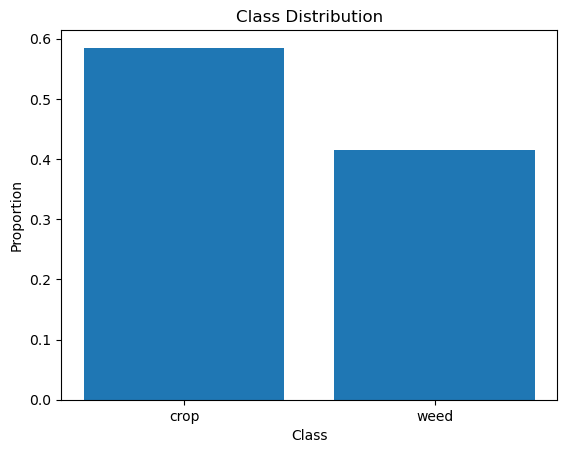

In [26]:
# Print the class distribution
class_dist = data['class'].value_counts(normalize=True)
print('Class distribution:\n', class_dist)

# Plot the class distribution
plt.bar(class_dist.index, class_dist.values)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Distribution')
plt.show()


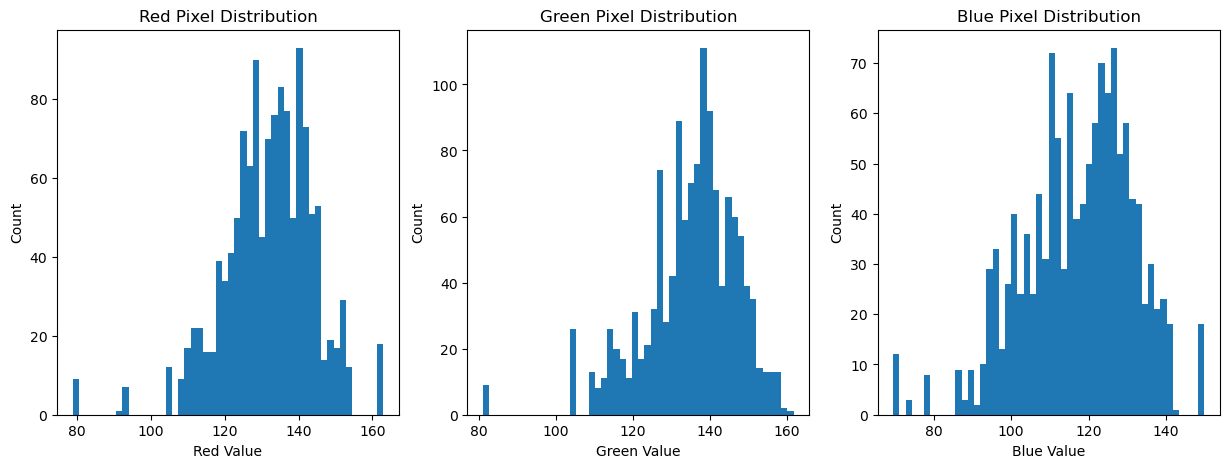

In [27]:
# Get the average RGB values
r_vals = []
g_vals = []
b_vals = []
for i in range(len(images)):
    img = cv2.imread(images[i])
    b,g,r = cv2.split(img)
    r_vals.append(np.mean(r))
    g_vals.append(np.mean(g))
    b_vals.append(np.mean(b))

# Plot the RGB distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(r_vals, bins=50)
axs[0].set_xlabel('Red Value')
axs[0].set_ylabel('Count')
axs[0].set_title('Red Pixel Distribution')
axs[1].hist(g_vals, bins=50)
axs[1].set_xlabel('Green Value')
axs[1].set_ylabel('Count')
axs[1].set_title('Green Pixel Distribution')
axs[2].hist(b_vals, bins=50)
axs[2].set_xlabel('Blue Value')
axs[2].set_ylabel('Count')
axs[2].set_title('Blue Pixel Distribution')
plt.show()


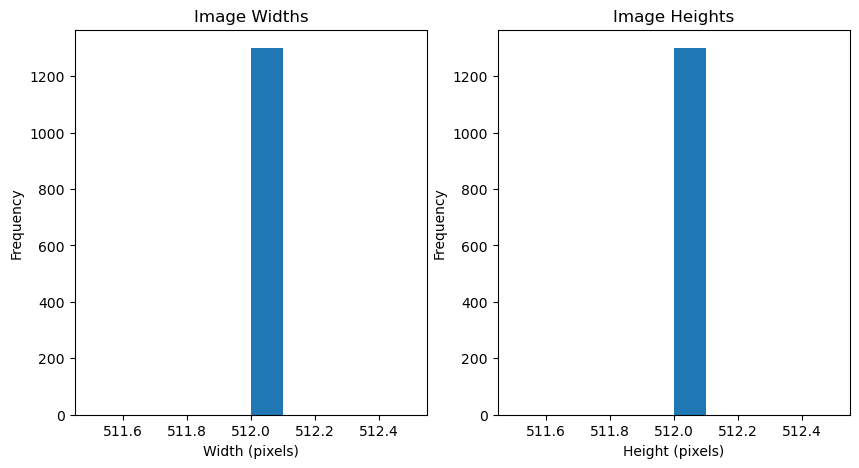

In [28]:
# Image dimension distribution
widths = []
heights = []

for img in images:
    with Image.open(img) as im:
        widths.append(im.width)
        heights.append(im.height)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(widths)
axs[0].set_title("Image Widths")
axs[0].set_xlabel("Width (pixels)")
axs[0].set_ylabel("Frequency")
axs[1].hist(heights)
axs[1].set_title("Image Heights")
axs[1].set_xlabel("Height (pixels)")
axs[1].set_ylabel("Frequency")
plt.show()

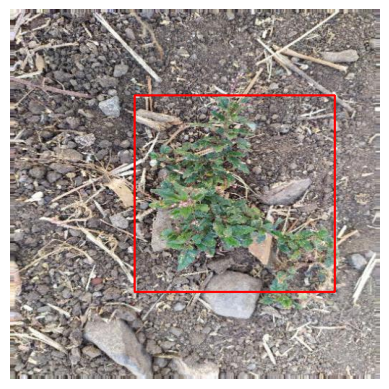

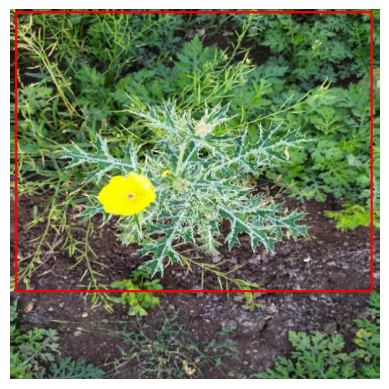

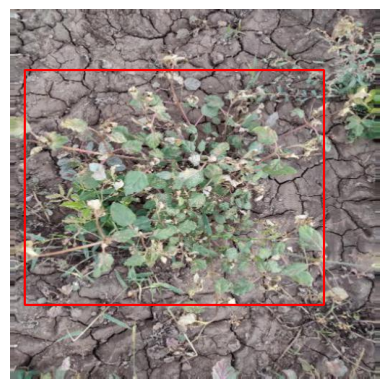

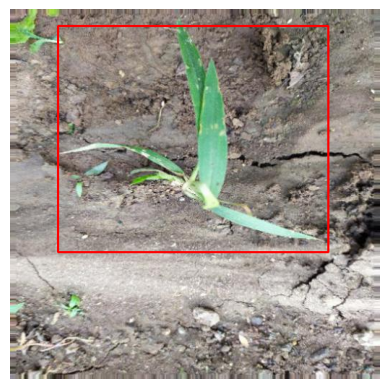

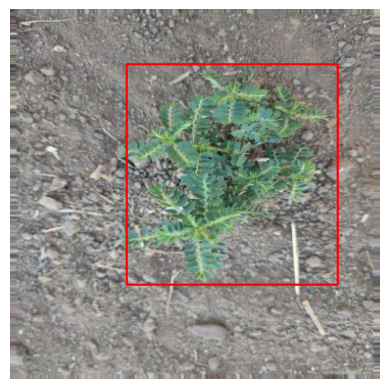

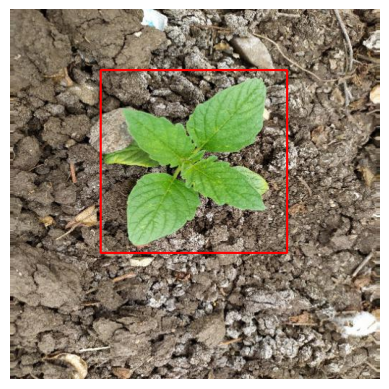

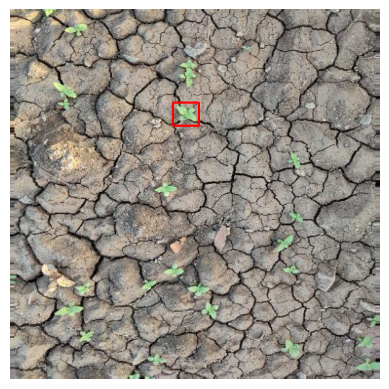

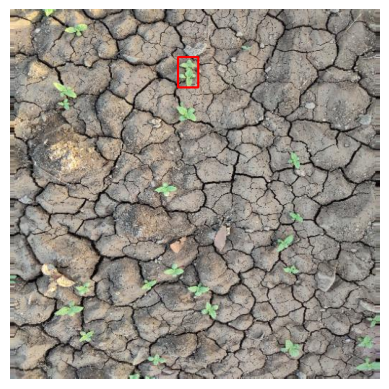

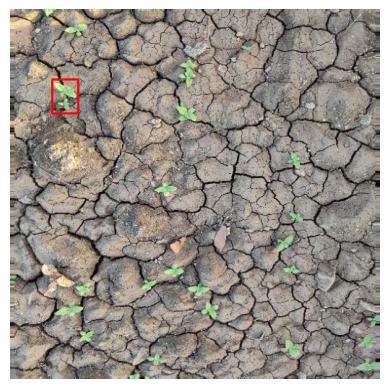

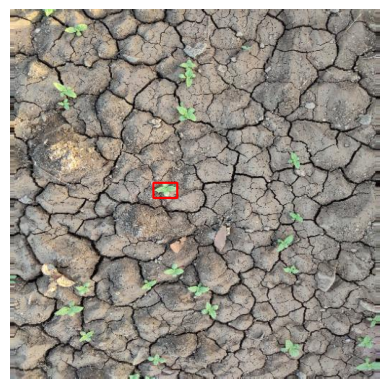

In [49]:
# Plot image with bounding box
def plot_image(image_path, xmin, ymin, xmax, ymax):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize images with bounding boxes
for i in range(10):
    image_path = df.iloc[i]['filename']
    xmin = df.iloc[i]['xmin']
    ymin = df.iloc[i]['ymin']
    xmax = df.iloc[i]['xmax']
    ymax = df.iloc[i]['ymax']
    plot_image(image_path, xmin, ymin, xmax, ymax)


In [ ]:
df = data.copy()

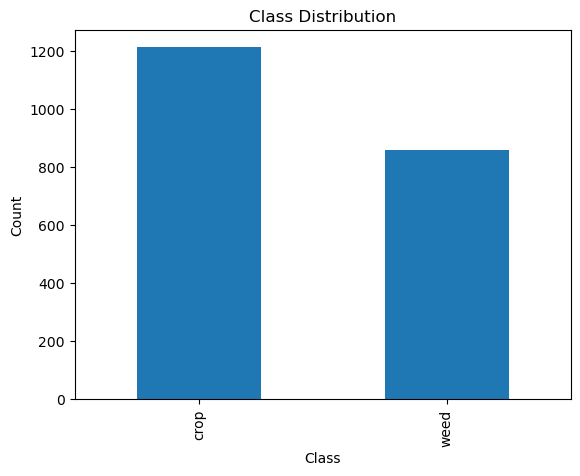

In [50]:
# Histogram of class distribution
class_counts = df['class'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

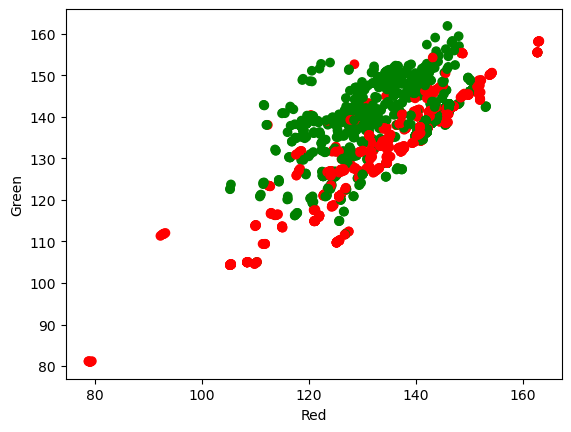

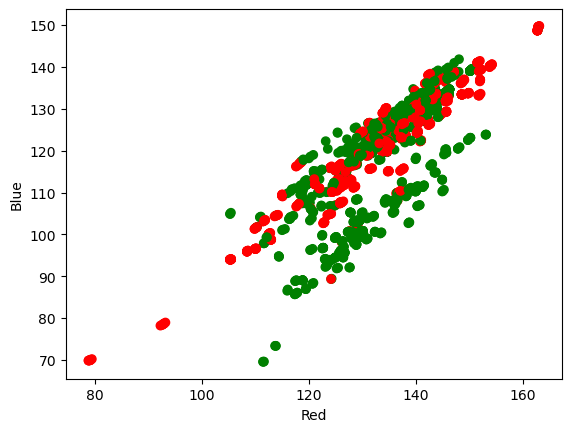

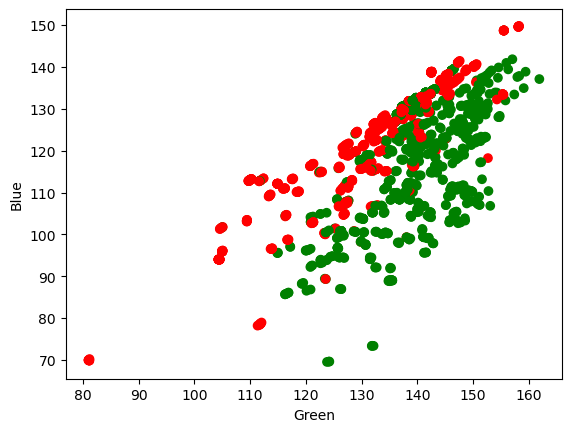

In [52]:
# Average color of images
def get_average_color(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    average_color = [image[:, :, i].mean() for i in range(3)]
    return average_color

df['average_color'] = df['filename'].apply(get_average_color)
df['red'] = df['average_color'].apply(lambda x: x[0])
df['green'] = df['average_color'].apply(lambda x: x[1])
df['blue'] = df['average_color'].apply(lambda x: x[2])

# RGB scatter plot with class labels
plt.scatter(df['red'], df['green'], c=df['class'].map({'crop': 'green', 'weed': 'red'}))
plt.xlabel('Red')
plt.ylabel('Green')
plt.show()

plt.scatter(df['red'], df['blue'], c=df['class'].map({'crop': 'green', 'weed': 'red'}))
plt.xlabel('Red')
plt.ylabel('Blue')
plt.show()

plt.scatter(df['green'], df['blue'], c=df['class'].map({'crop': 'green', 'weed': 'red'}))
plt.xlabel('Green')
plt.ylabel('Blue')
plt.show()

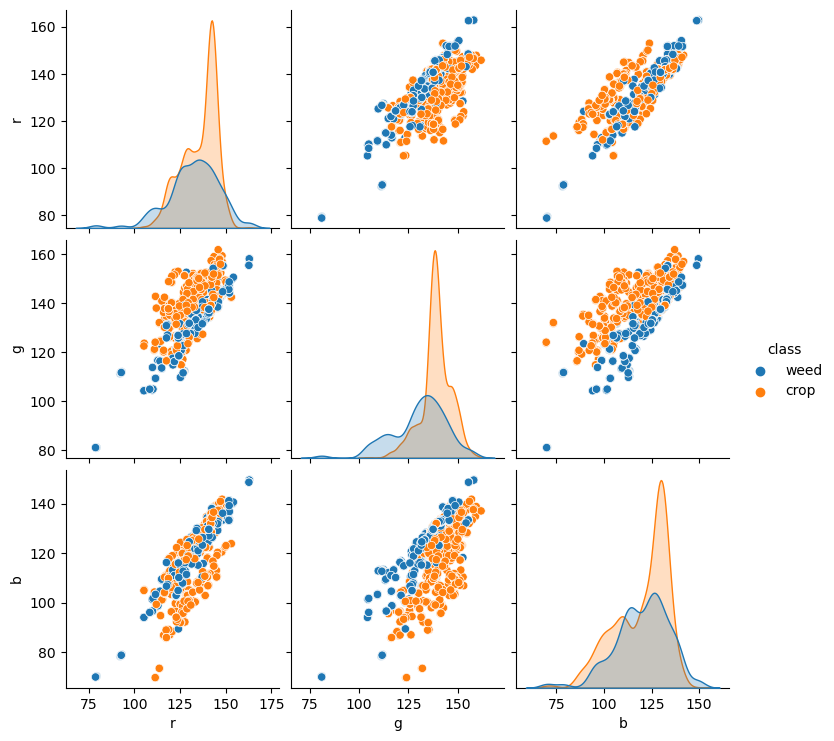

In [43]:
# Extract RGB color values from the images
rgb_values = []
for i, row in df.iterrows():
    image = plt.imread(row['filename'])
    r, g, b = image.mean(axis=0).mean(axis=0)
    rgb_values.append((r, g, b))

# Add RGB color values to the dataframe
df['r'] = [x[0] for x in rgb_values]
df['g'] = [x[1] for x in rgb_values]
df['b'] = [x[2] for x in rgb_values]

# Plot a pairplot based on the RGB color values and class labels
sns.pairplot(df, hue='class', vars=['r', 'g', 'b'])

In [54]:
data.to_csv('./dataset/data.csv', index=False)